In this example, we will compare effectiveness of various stop signals across multiple cryptocurrencies and time ranges. 

We will conduct in total 1,830,000 tests. First, we will pick and fetch 2 years of daily pricing data for 10 cryptocurrencies of main interest. For each one, we will split the entire history into 367 (overlapping) time ranges each 1 year long and select the first date of each range as a buy signal. For each such signal, we will test 100 different stop loss (SL), trailing stop (TS), and take profit (TP) values with 1% increment. These will be our exit signals stored in separate variables. We will also generate random exit signals in our third variable to be able to compare effectiveness of stop exits with that of random exits. Finally, we will calculate performance of all strategies and compare them interactivelly. Thanks to vectorbt, such tests can be done in a matter of minutes. You can also change any of the parameters mentioned above at the beginning of the notebook.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
import itertools
import yfinance as yf
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional
import ipywidgets

In [3]:
a = pd.Index(['a', 'b', 'c'], name='name1')
b = pd.MultiIndex.from_tuples([
    (0, 'a'),
    (0, 'b'),
    (0, 'c'),
    (1, 'a'),
    (1, 'b'),
    (1, 'c')
], names=['name2', 'name1'])
c = pd.MultiIndex.from_tuples([
    (2, 0, 'a'),
    (2, 0, 'b'),
    (2, 0, 'c'),
    (2, 1, 'a'),
    (2, 1, 'b'),
    (2, 1, 'c'),
    (3, 0, 'a'),
    (3, 0, 'b'),
    (3, 0, 'c'),
    (3, 1, 'a'),
    (3, 1, 'b'),
    (3, 1, 'c')
], names=['name3', 'name2', 'name1'])
df_a = pd.DataFrame([np.arange(len(a))], columns=a)
df_b = pd.DataFrame([np.arange(len(b))], columns=b)
df_c = pd.DataFrame([np.arange(len(c))], columns=c)
df_a, df_b, df_c = vbt.base.reshape_fns.broadcast(df_a, df_b, df_c)
print(df_a)
print(df_b)
print(df_c)

name3  2                 3               
name2  0        1        0        1      
name1  a  b  c  a  b  c  a  b  c  a  b  c
0      0  1  2  0  1  2  0  1  2  0  1  2
name3  2                 3               
name2  0        1        0        1      
name1  a  b  c  a  b  c  a  b  c  a  b  c
0      0  1  2  3  4  5  0  1  2  3  4  5
name3  2                 3                 
name2  0        1        0        1        
name1  a  b  c  a  b  c  a  b  c  a   b   c
0      0  1  2  3  4  5  6  7  8  9  10  11


In [4]:
# Define your params here
seed = 42
asset_names = [
    'BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 
    'BNB-USD', 'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD']

history_len = timedelta(days=365*2)
end_date = datetime.now()
start_date = end_date - history_len
time_window = timedelta(days=365) # length of a time window
freq = '1D'

stops = np.arange(0, 1, 0.01) # in %

vbt.defaults.portfolio['init_cash'] = 100. # in $
vbt.defaults.portfolio['fees'] = 0.0025 # in %
vbt.defaults.portfolio['slippage'] = 0.0025 # in %

print(len(asset_names) * (history_len.days - time_window.days), 'experiments per stop value')
print(len(stops), 'stop values per stop type')
print(len(asset_names) * (history_len.days - time_window.days) * len(stops), 'experiments per stop type')

3650 experiments per stop value
100 stop values per stop type
365000 experiments per stop type


In [5]:
%%time
# Download data
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
asset_history = {k: yf.Ticker(k).history(start=start_date, end=end_date) for k in asset_names}
asset_history = {k: v[ohlcv_cols] for k, v in asset_history.items()}
asset_history = {k: v.astype(np.float64) for k, v in asset_history.items()}

for k, v in asset_history.items():
    print(k, v.shape)
    
print(asset_history['BTC-USD'].columns)

BTC-USD (730, 5)
ETH-USD (729, 5)
XRP-USD (730, 5)
BCH-USD (729, 5)
LTC-USD (730, 5)
BNB-USD (729, 5)
EOS-USD (729, 5)
XLM-USD (729, 5)
XMR-USD (730, 5)
ADA-USD (713, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
CPU times: user 751 ms, sys: 87.6 ms, total: 838 ms
Wall time: 3.17 s


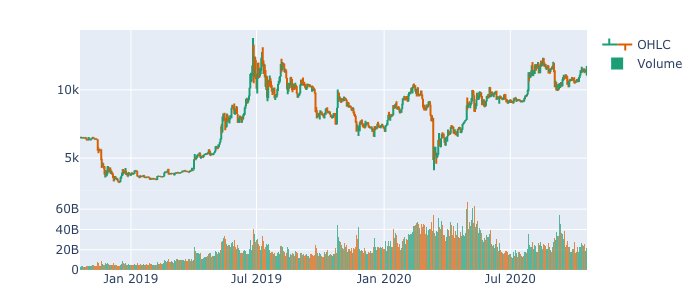

In [6]:
asset_history['BTC-USD'].vbt.ohlcv.plot().show_png()

In [7]:
%%time
# Stack all dfs along each column
prices = {}
for k in ohlcv_cols:
    price = pd.concat(map(lambda x: x[k], asset_history.values()), axis=1)
    price.columns = pd.Index(asset_history.keys(), name='asset_name')
    prices[k] = price

print(prices['Open'].shape)
print(prices['Open'].columns) # number of stocks

(730, 10)
Index(['BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD',
       'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD'],
      dtype='object', name='asset_name')
CPU times: user 38.6 ms, sys: 3.46 ms, total: 42.1 ms
Wall time: 40.9 ms


In [8]:
%%time
# Split the whole time period into time ranges
prices = {k: v.vbt.split_into_ranges(range_len=time_window.days) for k, v in prices.items()}
    
print(prices['Open'].shape)
print(prices['Open'].columns) # number of stocks x number of ranges

(365, 3660)
MultiIndex([('BTC-USD', '2018-10-20', '2019-10-19'),
            ('BTC-USD', '2018-10-21', '2019-10-20'),
            ('BTC-USD', '2018-10-22', '2019-10-21'),
            ('BTC-USD', '2018-10-23', '2019-10-22'),
            ('BTC-USD', '2018-10-24', '2019-10-23'),
            ('BTC-USD', '2018-10-25', '2019-10-24'),
            ('BTC-USD', '2018-10-26', '2019-10-25'),
            ('BTC-USD', '2018-10-27', '2019-10-26'),
            ('BTC-USD', '2018-10-28', '2019-10-27'),
            ('BTC-USD', '2018-10-29', '2019-10-28'),
            ...
            ('ADA-USD', '2019-10-11', '2020-10-10'),
            ('ADA-USD', '2019-10-12', '2020-10-11'),
            ('ADA-USD', '2019-10-13', '2020-10-12'),
            ('ADA-USD', '2019-10-14', '2020-10-13'),
            ('ADA-USD', '2019-10-15', '2020-10-14'),
            ('ADA-USD', '2019-10-16', '2020-10-15'),
            ('ADA-USD', '2019-10-17', '2020-10-16'),
            ('ADA-USD', '2019-10-18', '2020-10-17'),
            ('ADA-

In [9]:
%%time
# Pick one entry signal at the beginning of each time range
entries = pd.DataFrame.vbt.signals.empty(prices['Open'].shape)
entries.iloc[0, :] = True

# Right now our rand signals have no meaningful columns
entries.columns = prices['Open'].columns

print(entries.shape)
print(entries.columns)

(365, 3660)
MultiIndex([('BTC-USD', '2018-10-20', '2019-10-19'),
            ('BTC-USD', '2018-10-21', '2019-10-20'),
            ('BTC-USD', '2018-10-22', '2019-10-21'),
            ('BTC-USD', '2018-10-23', '2019-10-22'),
            ('BTC-USD', '2018-10-24', '2019-10-23'),
            ('BTC-USD', '2018-10-25', '2019-10-24'),
            ('BTC-USD', '2018-10-26', '2019-10-25'),
            ('BTC-USD', '2018-10-27', '2019-10-26'),
            ('BTC-USD', '2018-10-28', '2019-10-27'),
            ('BTC-USD', '2018-10-29', '2019-10-28'),
            ...
            ('ADA-USD', '2019-10-11', '2020-10-10'),
            ('ADA-USD', '2019-10-12', '2020-10-11'),
            ('ADA-USD', '2019-10-13', '2020-10-12'),
            ('ADA-USD', '2019-10-14', '2020-10-13'),
            ('ADA-USD', '2019-10-15', '2020-10-14'),
            ('ADA-USD', '2019-10-16', '2020-10-15'),
            ('ADA-USD', '2019-10-17', '2020-10-16'),
            ('ADA-USD', '2019-10-18', '2020-10-17'),
            ('ADA-

In [10]:
%%time
# Generate stop exits
sl_advstex = vbt.ADVSTEX.run(
    entries, 
    prices['Open'], 
    prices['High'], 
    prices['Low'], 
    prices['Close'], 
    sl_stop=list(stops),
    stop_type=None  # not needed, do not fill
)
ts_advstex = vbt.ADVSTEX.run(
    entries, 
    prices['Open'], 
    prices['High'], 
    prices['Low'], 
    prices['Close'], 
    ts_stop=list(stops),
    stop_type=None
)
tp_advstex = vbt.ADVSTEX.run(
    entries, 
    prices['Open'], 
    prices['High'], 
    prices['Low'], 
    prices['Close'], 
    tp_stop=list(stops),
    stop_type=None
)

# Exit signals
sl_exits = sl_advstex.exits
ts_exits = ts_advstex.exits
tp_exits = tp_advstex.exits

# Hit prices
sl_hit_price = sl_advstex.hit_price
ts_hit_price = ts_advstex.hit_price
tp_hit_price = tp_advstex.hit_price

del sl_advstex
del ts_advstex
del tp_advstex

print(sl_exits.shape, ts_exits.shape, tp_exits.shape)
print(sl_exits.columns)

(365, 366000) (365, 366000) (365, 366000)
MultiIndex([( 0.0, 'BTC-USD', '2018-10-20', '2019-10-19'),
            ( 0.0, 'BTC-USD', '2018-10-21', '2019-10-20'),
            ( 0.0, 'BTC-USD', '2018-10-22', '2019-10-21'),
            ( 0.0, 'BTC-USD', '2018-10-23', '2019-10-22'),
            ( 0.0, 'BTC-USD', '2018-10-24', '2019-10-23'),
            ( 0.0, 'BTC-USD', '2018-10-25', '2019-10-24'),
            ( 0.0, 'BTC-USD', '2018-10-26', '2019-10-25'),
            ( 0.0, 'BTC-USD', '2018-10-27', '2019-10-26'),
            ( 0.0, 'BTC-USD', '2018-10-28', '2019-10-27'),
            ( 0.0, 'BTC-USD', '2018-10-29', '2019-10-28'),
            ...
            (0.99, 'ADA-USD', '2019-10-11', '2020-10-10'),
            (0.99, 'ADA-USD', '2019-10-12', '2020-10-11'),
            (0.99, 'ADA-USD', '2019-10-13', '2020-10-12'),
            (0.99, 'ADA-USD', '2019-10-14', '2020-10-13'),
            (0.99, 'ADA-USD', '2019-10-15', '2020-10-14'),
            (0.99, 'ADA-USD', '2019-10-16', '2020-10-15')

0.49356010928961747
0.7078469945355191
0.6377295081967214


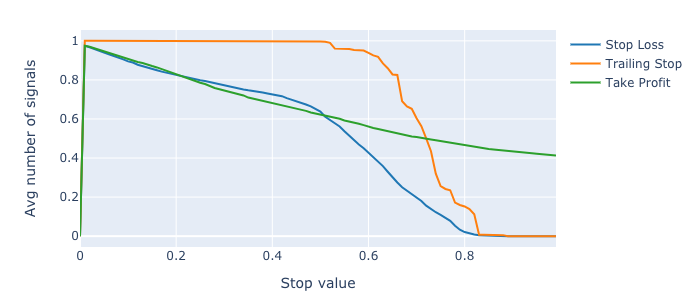

CPU times: user 1.17 s, sys: 19.7 ms, total: 1.19 s
Wall time: 1.28 s


In [12]:
%%time
# How many exit signals our orders have generated per column and on average?
print(sl_exits.vbt.signals.num_signals().mean())
print(ts_exits.vbt.signals.num_signals().mean())
print(tp_exits.vbt.signals.num_signals().mean())

stop_cols = sl_exits.columns.get_level_values('advstex_sl_stop').to_numpy()

pd.DataFrame({
    'Stop Loss': sl_exits.vbt.signals.num_signals().groupby(stop_cols).mean(),
    'Trailing Stop': ts_exits.vbt.signals.num_signals().groupby(stop_cols).mean(),
    'Take Profit': tp_exits.vbt.signals.num_signals().groupby(stop_cols).mean()
}).vbt.scatter(xaxis_title='Stop value', yaxis_title='Avg number of signals').show_png()

In [13]:
%%time
# Pick one exit signal at the end of each time range
hold_exits = pd.DataFrame.vbt.signals.empty_like(sl_exits)
hold_exits.iloc[-1, :] = True

print(hold_exits.shape)
print(hold_exits.columns)

(365, 366000)
MultiIndex([( 0.0, 'BTC-USD', '2018-10-20', '2019-10-19'),
            ( 0.0, 'BTC-USD', '2018-10-21', '2019-10-20'),
            ( 0.0, 'BTC-USD', '2018-10-22', '2019-10-21'),
            ( 0.0, 'BTC-USD', '2018-10-23', '2019-10-22'),
            ( 0.0, 'BTC-USD', '2018-10-24', '2019-10-23'),
            ( 0.0, 'BTC-USD', '2018-10-25', '2019-10-24'),
            ( 0.0, 'BTC-USD', '2018-10-26', '2019-10-25'),
            ( 0.0, 'BTC-USD', '2018-10-27', '2019-10-26'),
            ( 0.0, 'BTC-USD', '2018-10-28', '2019-10-27'),
            ( 0.0, 'BTC-USD', '2018-10-29', '2019-10-28'),
            ...
            (0.99, 'ADA-USD', '2019-10-11', '2020-10-10'),
            (0.99, 'ADA-USD', '2019-10-12', '2020-10-11'),
            (0.99, 'ADA-USD', '2019-10-13', '2020-10-12'),
            (0.99, 'ADA-USD', '2019-10-14', '2020-10-13'),
            (0.99, 'ADA-USD', '2019-10-15', '2020-10-14'),
            (0.99, 'ADA-USD', '2019-10-16', '2020-10-15'),
            (0.99, 'ADA-US

In [14]:
%%time
# Combine exits with stop loss exits
sl_exits = hold_exits.vbt | sl_exits  # use .vbt to use vectorbt's broadcasting rules
ts_exits = hold_exits.vbt | ts_exits
tp_exits = hold_exits.vbt | tp_exits

print(sl_exits.vbt.signals.num_signals().mean())
print(ts_exits.vbt.signals.num_signals().mean())
print(tp_exits.vbt.signals.num_signals().mean())

1.4929726775956285
1.7073661202185793
1.6371775956284154
CPU times: user 980 ms, sys: 192 ms, total: 1.17 s
Wall time: 1.23 s


In [15]:
%%time
# Select the first exit signal after each entry
sl_exits = sl_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)
ts_exits = ts_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)
tp_exits = tp_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)

print(sl_exits.vbt.signals.num_signals().mean())
print(ts_exits.vbt.signals.num_signals().mean())
print(tp_exits.vbt.signals.num_signals().mean())

1.0
1.0
1.0
CPU times: user 14.3 s, sys: 2.41 s, total: 16.7 s
Wall time: 17.5 s


In [16]:
%%time
# To compare our stop loss orders with random trading strategy we need to place random exits
# After each entry signal place exactly one exit signal randomly
rand_exits = entries.vbt.tile(len(stops)).vbt.signals.generate_random_exits(seed=seed)

assert(rand_exits.shape == sl_exits.shape)

CPU times: user 7.28 s, sys: 191 ms, total: 7.47 s
Wall time: 7.65 s


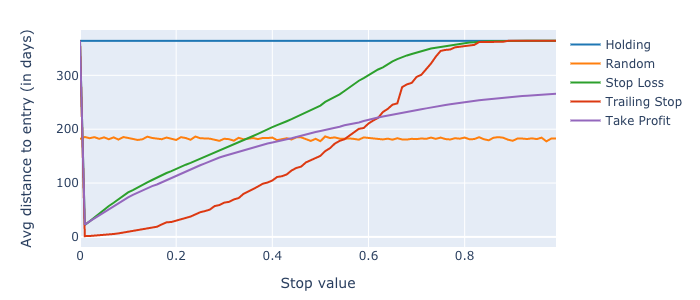

CPU times: user 8.03 s, sys: 554 ms, total: 8.58 s
Wall time: 8.71 s


In [17]:
%%time
# And what is the average distance to the entry signal?
@njit
def map_func_nb(col, entry_i, exit_i):
    return exit_i - entry_i # distance

@njit
def reduce_func_nb(col, a):
    return np.nanmean(a) # average of all distances

pd.DataFrame({
    'Holding': entries.vbt.signals.map_reduce_between(
        other=hold_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Random': entries.vbt.signals.map_reduce_between(
        other=rand_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Stop Loss': entries.vbt.signals.map_reduce_between(
        other=sl_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Trailing Stop': entries.vbt.signals.map_reduce_between(
        other=ts_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Take Profit': entries.vbt.signals.map_reduce_between(
        other=tp_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean()
}).vbt.scatter(xaxis_title='Stop value', yaxis_title='Avg distance to entry (in days)').show_png()

In [18]:
%%time
# Compute fill price by merging hit prices
# Since entries are the same for each stop, hit prices do not overlap and can be safely merged
fill_price = prices['Close'].vbt.combine_with_multiple(
    [sl_hit_price, ts_hit_price, tp_hit_price],
    combine_func=lambda x, y: np.where(np.isnan(y), x, y)
)

CPU times: user 6.8 s, sys: 10.4 s, total: 17.2 s
Wall time: 28.7 s


In [19]:
%%time
# Check whether we merged prices correctly
@njit
def check_fill_price_nb(fill_price, sl_hit_price, ts_hit_price, tp_hit_price):
    for i in range(fill_price.shape[0]):
        for col in range(fill_price.shape[1]):
            if not np.isnan(tp_hit_price[i, col]):
                assert fill_price[i, col] == tp_hit_price[i, col]
            elif not np.isnan(ts_hit_price[i, col]):
                assert fill_price[i, col] == ts_hit_price[i, col]
            elif not np.isnan(sl_hit_price[i, col]):
                assert fill_price[i, col] == sl_hit_price[i, col]
                
check_fill_price_nb(
    fill_price.values, 
    sl_hit_price.values, 
    ts_hit_price.values, 
    tp_hit_price.values
)

del sl_hit_price
del ts_hit_price
del tp_hit_price

CPU times: user 1.36 s, sys: 4.14 s, total: 5.5 s
Wall time: 8.21 s


In [20]:
import gc

gc.collect()

14032

In [21]:
%%time
# Calculate portfolio performance
# Performance of plain holding
hold_portfolio = vbt.Portfolio.from_signals(
    prices['Close'], entries, hold_exits, entry_price=prices['Open'], exit_price=prices['Close'], freq=freq)

hold_performance = hold_portfolio.total_return()
del hold_portfolio

print(hold_performance.shape)
print(hold_performance.mean())

(366000,)
0.0974527972340613
CPU times: user 9.25 s, sys: 4.88 s, total: 14.1 s
Wall time: 19 s


In [22]:
%%time
# Performance of trading with random exits
rand_portfolio = vbt.Portfolio.from_signals(
    prices['Close'], entries, rand_exits, entry_price=prices['Open'], exit_price=prices['Close'], freq=freq)

rand_performance = rand_portfolio.total_return()
del rand_portfolio

print(rand_performance.shape)
print(rand_performance.mean())

(366000,)
0.1288815337752961
CPU times: user 11.5 s, sys: 14.6 s, total: 26.1 s
Wall time: 43.8 s


In [23]:
%%time
# Performance of trading with stop loss
sl_portfolio = vbt.Portfolio.from_signals(
    prices['Close'], entries, sl_exits, entry_price=prices['Open'], exit_price=fill_price, freq=freq)

sl_performance = sl_portfolio.total_return()
del sl_portfolio

print(sl_performance.shape)
print(sl_performance.mean())

(366000,)
-0.0030377038077695866
CPU times: user 9.47 s, sys: 7.19 s, total: 16.7 s
Wall time: 24.4 s


In [24]:
%%time
# Performance of trading with trailing stop 
ts_portfolio = vbt.Portfolio.from_signals(
    prices['Close'], entries, ts_exits, entry_price=prices['Open'], exit_price=fill_price, freq=freq)

ts_performance = ts_portfolio.total_return()
del ts_portfolio

print(ts_performance.shape)
print(ts_performance.mean())

(366000,)
0.041404069034472996
CPU times: user 11 s, sys: 10.8 s, total: 21.8 s
Wall time: 31.5 s


In [25]:
%%time
# Performance of trading with take profit 
tp_portfolio = vbt.Portfolio.from_signals(
    prices['Close'], entries, tp_exits, entry_price=prices['Open'], exit_price=fill_price, freq=freq)

tp_performance = tp_portfolio.total_return()
del tp_portfolio

print(tp_performance.shape)
print(tp_performance.mean())

(366000,)
0.15576202077443133
CPU times: user 11.1 s, sys: 9.56 s, total: 20.7 s
Wall time: 28.9 s


In [27]:
# Plot performance of each strategy depending on the stop value and trend
# Trend is just the net return of this time period

# Widgets
assets = hold_performance.index.get_level_values('asset_name')
asset_dropdown = ipywidgets.Dropdown(
    options=['All'] + asset_names,
    value='All'
)
trend_dropdown = ipywidgets.Dropdown(
    options=['All', 'Positive', 'Negative'],
    value='All'
)
dates = hold_performance.index.get_level_values('range_start')
date_range_slider = ipywidgets.SelectionRangeSlider(
    options=dates.unique(),
    index=(0, len(dates.unique())-1),
    orientation='horizontal',
    readout=False
)
date_range_label = ipywidgets.Label()
scatter_fig = vbt.plotting.create_scatter(
    trace_names=['Holding', 'Random', 'Stop Loss', 'Trailing Stop', 'Take Profit'],
    x_labels=stops, 
    xaxis_title='Stop value', 
    yaxis_title='Avg total return')
scatter_img = ipywidgets.Image(
    format='png',
    width=scatter_fig.layout.width,
    height=scatter_fig.layout.height
)

# Update function
def update_scatter(*args, **kwargs):
    trend = trend_dropdown.value
    asset = asset_dropdown.value
    date_range = date_range_slider.value
    
    # Build boolean mask based on selected values
    trend_mask = None
    asset_mask = None
    if trend == 'Positive':
        trend_mask = hold_performance.values > 0
    elif trend == 'Negative':
        trend_mask = hold_performance.values < 0
    if asset != 'All':
        asset_mask = assets == asset
    mask = (dates >= date_range[0]) & (dates <= date_range[1])
    if trend_mask is not None:
        mask = mask & trend_mask
    if asset_mask is not None:
        mask = mask & asset_mask
    
    # Update graph
    vbt.plotting.update_scatter_data(
        scatter_fig,
        np.asarray([
            hold_performance[mask].groupby(stop_cols[mask]).mean(),
            rand_performance[mask].groupby(stop_cols[mask]).mean(),
            sl_performance[mask].groupby(stop_cols[mask]).mean(),
            ts_performance[mask].groupby(stop_cols[mask]).mean(),
            tp_performance[mask].groupby(stop_cols[mask]).mean()
        ]).transpose()
    )
    scatter_img.value = scatter_fig.to_image(format="png")
    
    # Update date range label
    date_range_label.value = '{:%d %b %Y} - {:%d %b %Y}'.format(date_range[0], date_range[1])

# Hooks
asset_dropdown.observe(update_scatter, names='value')
trend_dropdown.observe(update_scatter, names='value')
date_range_slider.observe(update_scatter, names='value')
update_scatter()

# Widget hierarchy
dashboard = ipywidgets.VBox([
    ipywidgets.HBox([
        ipywidgets.Label('Asset:'),
        asset_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Trend:'),
        trend_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Date range:'),
        date_range_slider,
        date_range_label
    ]),
    scatter_img
])
dashboard

In [28]:
dashboard.close() # after using, release memory and notebook metadata